In [286]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.metrics import classification_report


In [287]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.0)

%matplotlib inline

# Set Options for display
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [288]:
df = pd.read_csv('assets/test.csv')
df.head(2)

ID Customer_ID      Month           Name Age          SSN Occupation   
0  0x160a   CUS_0xd40  September  Aaron Maashoh  23  821-00-0265  Scientist  \
1  0x160b   CUS_0xd40    October  Aaron Maashoh  24  821-00-0265  Scientist   

  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card   
0      19114.12                1824.84                  3                4  \
1      19114.12                1824.84                  3                4   

   Interest_Rate Num_of_Loan   
0              3           4  \
1              3           4   

                                        Type_of_Loan  Delay_from_due_date   
0  Auto Loan, Credit-Builder Loan, Personal Loan,...                    3  \
1  Auto Loan, Credit-Builder Loan, Personal Loan,...                    3   

  Num_of_Delayed_Payment Changed_Credit_Limit  Num_Credit_Inquiries   
0                      7                11.27               2022.00  \
1                      9                13.27                  4.00   

  Credit_Mix Outstanding_Debt  Credit_Utilization_Ratio   
0       Good           809.98                     35.03  \
1       Good           809.98                     33.05   

       Credit_History_Age Payment_of_Min_Amount  Total_EMI_per_month   
0   22 Years and 9 Months                    No                49.57  \
1  22 Years and 10 Months                    No                49.57   

  Amount_invested_monthly                 Payment_Behaviour   
0      236.64268203272135    Low_spent_Small_value_payments  \
1      21.465380264657146  High_spent_Medium_value_payments   

      Monthly_Balance  
0  186.26670208571772  
1  361.44400385378196

In [289]:
df.columns = [x.lower() for x in df.columns]
df.columns

Index(['id', 'customer_id', 'month', 'name', 'age', 'ssn', 'occupation',
       'annual_income', 'monthly_inhand_salary', 'num_bank_accounts',
       'num_credit_card', 'interest_rate', 'num_of_loan', 'type_of_loan',
       'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit',
       'num_credit_inquiries', 'credit_mix', 'outstanding_debt',
       'credit_utilization_ratio', 'credit_history_age',
       'payment_of_min_amount', 'total_emi_per_month',
       'amount_invested_monthly', 'payment_behaviour', 'monthly_balance'],
      dtype='object')

## Checking Data Quality

In [290]:
df.shape

(50000, 27)

In [291]:
# Dropping not needed columns
df.drop(['id', 'customer_id', 'month', 'name', 'ssn', 'type_of_loan', 'credit_history_age'], axis=1, inplace=True)

In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       50000 non-null  object 
 1   occupation                50000 non-null  object 
 2   annual_income             50000 non-null  object 
 3   monthly_inhand_salary     42502 non-null  float64
 4   num_bank_accounts         50000 non-null  int64  
 5   num_credit_card           50000 non-null  int64  
 6   interest_rate             50000 non-null  int64  
 7   num_of_loan               50000 non-null  object 
 8   delay_from_due_date       50000 non-null  int64  
 9   num_of_delayed_payment    46502 non-null  object 
 10  changed_credit_limit      50000 non-null  object 
 11  num_credit_inquiries      48965 non-null  float64
 12  credit_mix                50000 non-null  object 
 13  outstanding_debt          50000 non-null  object 
 14  credit

In [293]:
df.duplicated().value_counts()

False    50000
Name: count, dtype: int64

In [294]:
df.isnull().sum().reset_index().rename(columns={'index': 'feature_name', 0: 'null_counts'})

feature_name  null_counts
0                        age            0
1                 occupation            0
2              annual_income            0
3      monthly_inhand_salary         7498
4          num_bank_accounts            0
5            num_credit_card            0
6              interest_rate            0
7                num_of_loan            0
8        delay_from_due_date            0
9     num_of_delayed_payment         3498
10      changed_credit_limit            0
11      num_credit_inquiries         1035
12                credit_mix            0
13          outstanding_debt            0
14  credit_utilization_ratio            0
15     payment_of_min_amount            0
16       total_emi_per_month            0
17   amount_invested_monthly         2271
18         payment_behaviour            0
19           monthly_balance          562

In [295]:
df.shape[0]

50000

In [296]:
# Dropping the null values (with threshold)
size_before_cleaning = df.shape
df = df[df.isnull().sum(axis=1) <3]
print("{} Records dropped".format(size_before_cleaning[0] - df.shape[0]))

73 Records dropped


In [297]:
df.head()

age occupation annual_income  monthly_inhand_salary  num_bank_accounts   
0   23  Scientist      19114.12                1824.84                  3  \
1   24  Scientist      19114.12                1824.84                  3   
2   24  Scientist      19114.12                1824.84                  3   
3  24_  Scientist      19114.12                    NaN                  3   
4   28    _______      34847.84                3037.99                  2   

   num_credit_card  interest_rate num_of_loan  delay_from_due_date   
0                4              3           4                    3  \
1                4              3           4                    3   
2                4              3           4                   -1   
3                4              3           4                    4   
4                4              6           1                    3   

  num_of_delayed_payment changed_credit_limit  num_credit_inquiries   
0                      7                11.27               2022.00  \
1                      9                13.27                  4.00   
2                      4                12.27                  4.00   
3                      5                11.27                  4.00   
4                      1                 5.42                  5.00   

  credit_mix outstanding_debt  credit_utilization_ratio payment_of_min_amount   
0       Good           809.98                     35.03                    No  \
1       Good           809.98                     33.05                    No   
2       Good           809.98                     33.81                    No   
3       Good           809.98                     32.43                    No   
4       Good           605.03                     25.93                    No   

   total_emi_per_month amount_invested_monthly   
0                49.57      236.64268203272135  \
1                49.57      21.465380264657146   
2                49.57      148.23393788500925   
3                49.57       39.08251089460281   
4                18.82      39.684018417945296   

                  payment_behaviour     monthly_balance  
0    Low_spent_Small_value_payments  186.26670208571772  
1  High_spent_Medium_value_payments  361.44400385378196  
2   Low_spent_Medium_value_payments  264.67544623342997  
3  High_spent_Medium_value_payments  343.82687322383634  
4   High_spent_Large_value_payments   485.2984336755923

In [298]:
def amount_invested_monthly(col):
    if "__" in str(col):
        return str(col).split("__")[1]
    else:
        return str(col)

In [299]:
df["amount_invested_monthly"] = df["amount_invested_monthly"].apply(amount_invested_monthly)
df["amount_invested_monthly"] = df["amount_invested_monthly"].astype("float")


In [300]:
df.head()

age occupation annual_income  monthly_inhand_salary  num_bank_accounts   
0   23  Scientist      19114.12                1824.84                  3  \
1   24  Scientist      19114.12                1824.84                  3   
2   24  Scientist      19114.12                1824.84                  3   
3  24_  Scientist      19114.12                    NaN                  3   
4   28    _______      34847.84                3037.99                  2   

   num_credit_card  interest_rate num_of_loan  delay_from_due_date   
0                4              3           4                    3  \
1                4              3           4                    3   
2                4              3           4                   -1   
3                4              3           4                    4   
4                4              6           1                    3   

  num_of_delayed_payment changed_credit_limit  num_credit_inquiries   
0                      7                11.27               2022.00  \
1                      9                13.27                  4.00   
2                      4                12.27                  4.00   
3                      5                11.27                  4.00   
4                      1                 5.42                  5.00   

  credit_mix outstanding_debt  credit_utilization_ratio payment_of_min_amount   
0       Good           809.98                     35.03                    No  \
1       Good           809.98                     33.05                    No   
2       Good           809.98                     33.81                    No   
3       Good           809.98                     32.43                    No   
4       Good           605.03                     25.93                    No   

   total_emi_per_month  amount_invested_monthly   
0                49.57                   236.64  \
1                49.57                    21.47   
2                49.57                   148.23   
3                49.57                    39.08   
4                18.82                    39.68   

                  payment_behaviour     monthly_balance  
0    Low_spent_Small_value_payments  186.26670208571772  
1  High_spent_Medium_value_payments  361.44400385378196  
2   Low_spent_Medium_value_payments  264.67544623342997  
3  High_spent_Medium_value_payments  343.82687322383634  
4   High_spent_Large_value_payments   485.2984336755923

In [301]:
def filter_delayed_payments(value):
    if "__" in str(value):
        return str(value).split("__")[1]
    elif '_' in str(value):
        return str(value).replace('_', '')
    elif str(value) == '_':
        return str(value)
    else:
        return str(value)

In [302]:
df['num_of_delayed_payment'] = df["num_of_delayed_payment"].apply(filter_delayed_payments)
df['num_of_delayed_payment'] = df["num_of_delayed_payment"].astype(np.float64)

In [303]:
def filter_general(value):
    if '-' in str(value):
        return str(value).split("-")[1]
    elif '_' in str(value):
        return str(value).split('_')[0]
    else:
        return value

In [304]:
df.drop(df[df["monthly_balance"]=='__-333333333333333333333333333__'].index, inplace=True)
for i in ['age', 'annual_income', 'num_of_loan', 'outstanding_debt', 'monthly_balance']:
  df[i] = df[i].apply(filter_general)
  df[i] = df[i].astype(np.float64)
  print(i + " Successfully Cleaned")

age Successfully Cleaned
annual_income Successfully Cleaned
num_of_loan Successfully Cleaned
outstanding_debt Successfully Cleaned
monthly_balance Successfully Cleaned


In [305]:
df['changed_credit_Limit'] = df["changed_credit_limit"].apply(lambda x:x.split('-')[-1])
df.drop(df[df["changed_credit_limit"]=="_"].index, inplace=True)
df['changed_credit_limit'] = df["changed_credit_limit"].astype("float")

In [306]:
df['occupation'] = df['occupation'].replace('_______', np.nan)
df['occupation'] = df['occupation'].fillna(np.random.choice(pd.Series(['Scientist', 'Teacher', 'Engineer', 'Entrepreneur', 'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist', 'Media_Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer', 'Architect'])))

In [307]:
df['credit_mix'] = df["credit_mix"].replace('-', np.nan)
df['credit_mix'] = df["credit_mix"].fillna(np.random.choice(pd.Series(['Standard', 'Good', 'Bad'])))

In [308]:
df['payment_of_min_amount'] = df["payment_of_min_amount"].replace('NM', np.nan)
df['payment_of_min_amount'] = df["payment_of_min_amount"].fillna(np.random.choice(pd.Series(['Yes', 'No'])))

In [309]:
df['payment_behaviour'] = df["payment_behaviour"].replace('!@9#%8', np.nan)
df['payment_behaviour'] = df["payment_behaviour"].fillna(np.random.choice(pd.Series(['High_spent_Small_value_payments', 
'Low_spent_Large_value_payments'
'Low_spent_Small_value_payments', 'High_spent_Medium_value_payments', 
'High_spent_Large_value_payments', 
'Low_spent_Medium_value_payments', 
])))

In [310]:
for i in ['monthly_inhand_salary', 'num_of_delayed_payment', 'num_credit_inquiries', 'amount_invested_monthly', 'monthly_balance']:
    df[i].fillna(df[i].median(), inplace=True)

In [311]:
df.head()

age     occupation  annual_income  monthly_inhand_salary   
0 23.00      Scientist       19114.12                1824.84  \
1 24.00      Scientist       19114.12                1824.84   
2 24.00      Scientist       19114.12                1824.84   
3 24.00      Scientist       19114.12                3080.56   
4 28.00  Media_Manager       34847.84                3037.99   

   num_bank_accounts  num_credit_card  interest_rate  num_of_loan   
0                  3                4              3         4.00  \
1                  3                4              3         4.00   
2                  3                4              3         4.00   
3                  3                4              3         4.00   
4                  2                4              6         1.00   

   delay_from_due_date  num_of_delayed_payment  changed_credit_limit   
0                    3                    7.00                 11.27  \
1                    3                    9.00                 13.27   
2                   -1                    4.00                 12.27   
3                    4                    5.00                 11.27   
4                    3                    1.00                  5.42   

   num_credit_inquiries credit_mix  outstanding_debt   
0               2022.00       Good            809.98  \
1                  4.00       Good            809.98   
2                  4.00       Good            809.98   
3                  4.00       Good            809.98   
4                  5.00       Good            605.03   

   credit_utilization_ratio payment_of_min_amount  total_emi_per_month   
0                     35.03                    No                49.57  \
1                     33.05                    No                49.57   
2                     33.81                    No                49.57   
3                     32.43                    No                49.57   
4                     25.93                    No                18.82   

   amount_invested_monthly                 payment_behaviour  monthly_balance   
0                   236.64    Low_spent_Small_value_payments           186.27  \
1                    21.47  High_spent_Medium_value_payments           361.44   
2                   148.23   Low_spent_Medium_value_payments           264.68   
3                    39.08  High_spent_Medium_value_payments           343.83   
4                    39.68   High_spent_Large_value_payments           485.30   

  changed_credit_Limit  
0                11.27  
1                13.27  
2                12.27  
3                11.27  
4                 5.42

In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48864 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       48864 non-null  float64
 1   occupation                48864 non-null  object 
 2   annual_income             48864 non-null  float64
 3   monthly_inhand_salary     48864 non-null  float64
 4   num_bank_accounts         48864 non-null  int64  
 5   num_credit_card           48864 non-null  int64  
 6   interest_rate             48864 non-null  int64  
 7   num_of_loan               48864 non-null  float64
 8   delay_from_due_date       48864 non-null  int64  
 9   num_of_delayed_payment    48864 non-null  float64
 10  changed_credit_limit      48864 non-null  float64
 11  num_credit_inquiries      48864 non-null  float64
 12  credit_mix                48864 non-null  object 
 13  outstanding_debt          48864 non-null  float64
 14  credit_util

## Exploratory Data Analysis

In [313]:
df_cat = df.select_dtypes(include='object')
df_num = df.select_dtypes(include='number')

## Categorical Data 

In [314]:
df_cat.describe().T

count unique                             top   freq
occupation             48864     15                   Media_Manager   6425
credit_mix             48864      4                        Standard  17943
payment_of_min_amount  48864      2                             Yes  31420
payment_behaviour      48864      6  Low_spent_Small_value_payments  12396
changed_credit_Limit   48864   3480                            11.5     70

In [315]:
for cat_col in df_cat:
    print(df_cat[cat_col].value_counts())
    print('\n----------------------')

occupation
Media_Manager    6425
Lawyer           3233
Architect        3132
Engineer         3129
Mechanic         3101
Developer        3074
Accountant       3074
Scientist        3036
Entrepreneur     3030
Teacher          3029
Journalist       2973
Doctor           2958
Manager          2940
Musician         2870
Writer           2860
Name: count, dtype: int64

----------------------
credit_mix
Standard    17943
Good        11994
_            9592
Bad          9335
Name: count, dtype: int64

----------------------
payment_of_min_amount
Yes    31420
No     17444
Name: count, dtype: int64

----------------------
payment_behaviour
Low_spent_Small_value_payments      12396
Low_spent_Medium_value_payments     10392
High_spent_Medium_value_payments     8728
High_spent_Large_value_payments      6687
High_spent_Small_value_payments      5538
Low_spent_Large_value_payments       5123
Name: count, dtype: int64

----------------------
changed_credit_Limit
11.5                  70
11.32       

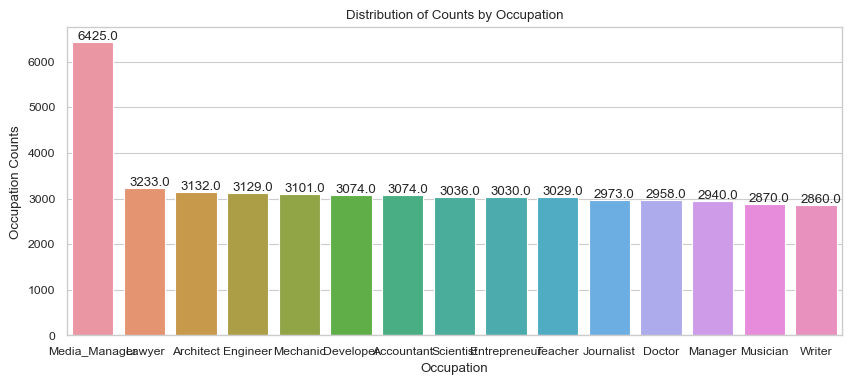

In [316]:
# Occupation
plt.figure(figsize=(10, 4))
ax = sns.countplot(x='occupation', data=df_cat, order = df['occupation'].value_counts().index)
plt.title('Distribution of Counts by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Occupation Counts')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

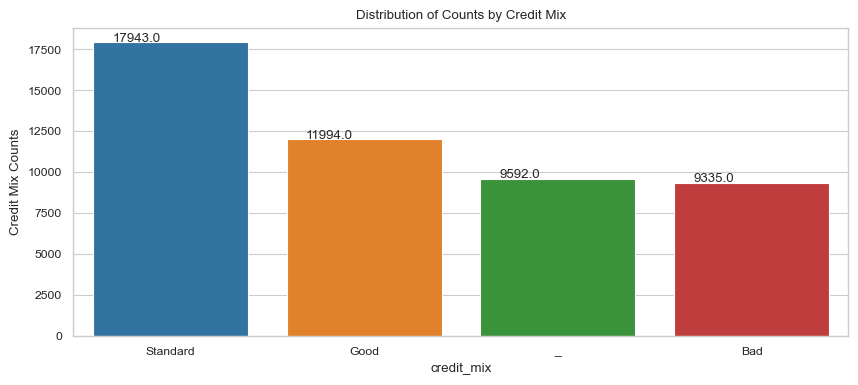

In [317]:
# Credit Mix
plt.figure(figsize=(10, 4))
ax = sns.countplot(x='credit_mix', data=df_cat, order = df['credit_mix'].value_counts().index)
plt.title('Distribution of Counts by Credit Mix')
plt.xlabel('credit_mix')
plt.ylabel('Credit Mix Counts')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

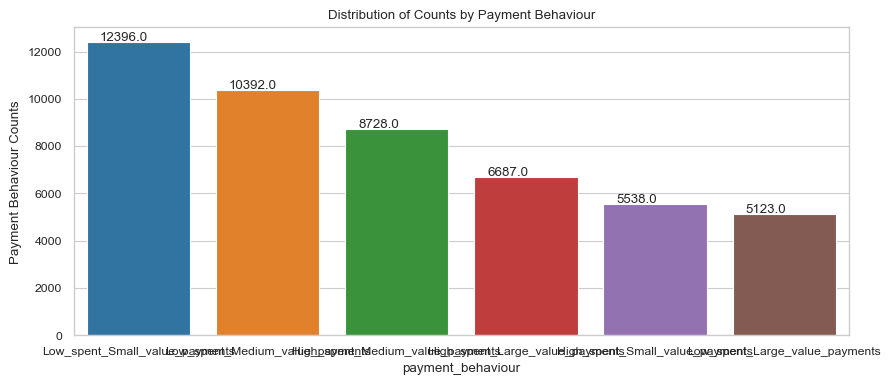

In [318]:
# Payment Behaviour
plt.figure(figsize=(10, 4))
ax = sns.countplot(x='payment_behaviour', data=df_cat, order = df['payment_behaviour'].value_counts().index)
plt.title('Distribution of Counts by Payment Behaviour')
plt.xlabel('payment_behaviour')
plt.ylabel('Payment Behaviour Counts')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

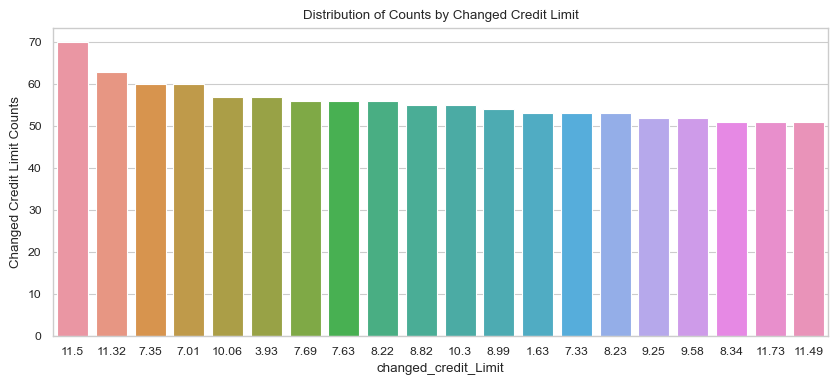

In [319]:
# Changed Credit Limit
# Payment of Min Amount
plt.figure(figsize=(10, 4))
ax = sns.countplot(x='changed_credit_Limit', data=df_cat, order = df['changed_credit_Limit'].value_counts().iloc[:20].index)
plt.title('Distribution of Counts by Changed Credit Limit')
plt.xlabel('changed_credit_Limit')
plt.ylabel('Changed Credit Limit Counts')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

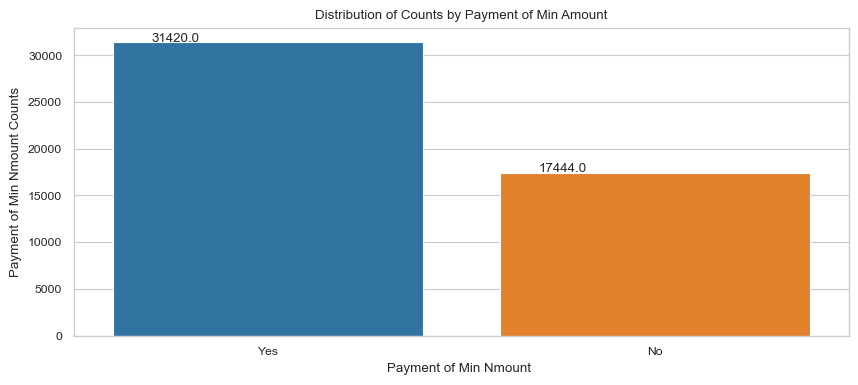

In [320]:
# Payment of Min Amount 
plt.figure(figsize=(10, 4))
ax = sns.countplot(x='payment_of_min_amount', data=df_cat, order = df['payment_of_min_amount'].value_counts().index)
plt.title('Distribution of Counts by Payment of Min Amount')
plt.xlabel('Payment of Min Nmount ')
plt.ylabel('Payment of Min Nmount Counts')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

## Numerical Data

In [321]:
df_num.describe()

age  annual_income  monthly_inhand_salary  num_bank_accounts   
count 48864.00       48864.00               48864.00           48864.00  \
mean    119.36      166476.83                4016.41              16.70   
std     680.66     1352094.98                2956.23             115.56   
min      14.00        7005.93                 303.65              -1.00   
25%      25.00       19428.03                1790.19               3.00   
50%      34.00       37471.52                3080.56               6.00   
75%      43.00       72790.92                5338.87               7.00   
max    8688.00    24137255.00               15204.63            1798.00   

       num_credit_card  interest_rate  num_of_loan  delay_from_due_date   
count         48864.00       48864.00     48864.00             48864.00  \
mean             22.96          69.30        11.24                21.04   
std             129.40         454.15        64.98                14.85   
min               0.00           1.00         0.00                -5.00   
25%               4.00           8.00         2.00                10.00   
50%               5.00          13.00         3.00                18.00   
75%               7.00          20.00         6.00                28.00   
max            1499.00        5799.00      1496.00                67.00   

       num_of_delayed_payment  changed_credit_limit  num_credit_inquiries   
count                48864.00              48864.00              48864.00  \
mean                    29.50                 10.37                 29.31   
std                    212.26                  6.78                193.39   
min                     -3.00                 -6.45                  0.00   
25%                      9.00                  5.34                  4.00   
50%                     14.00                  9.41                  7.00   
75%                     18.00                 14.80                 10.00   
max                   4399.00                 36.65               2593.00   

       outstanding_debt  credit_utilization_ratio  total_emi_per_month   
count          48864.00                  48864.00             48864.00  \
mean            1425.63                     32.28              1497.08   
std             1155.17                      5.10              8618.94   
min                0.23                     20.51                 0.00   
25%              565.48                     28.07                32.22   
50%             1165.77                     32.28                74.70   
75%             1945.19                     36.47               176.13   
max             4998.07                     48.54             82398.00   

       amount_invested_monthly  monthly_balance  
count                 48864.00         48864.00  
mean                    620.32           402.45  
std                    2013.70           212.67  
min                       0.00             0.10  
25%                      76.92           271.11  
50%                     135.42           337.11  
75%                     255.78           468.76  
max                   10000.00          1606.52

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'annual_income'}>,
        <Axes: title={'center': 'monthly_inhand_salary'}>,
        <Axes: title={'center': 'num_bank_accounts'}>],
       [<Axes: title={'center': 'num_credit_card'}>,
        <Axes: title={'center': 'interest_rate'}>,
        <Axes: title={'center': 'num_of_loan'}>,
        <Axes: title={'center': 'delay_from_due_date'}>],
       [<Axes: title={'center': 'num_of_delayed_payment'}>,
        <Axes: title={'center': 'changed_credit_limit'}>,
        <Axes: title={'center': 'num_credit_inquiries'}>,
        <Axes: title={'center': 'outstanding_debt'}>],
       [<Axes: title={'center': 'credit_utilization_ratio'}>,
        <Axes: title={'center': 'total_emi_per_month'}>,
        <Axes: title={'center': 'amount_invested_monthly'}>,
        <Axes: title={'center': 'monthly_balance'}>]], dtype=object)

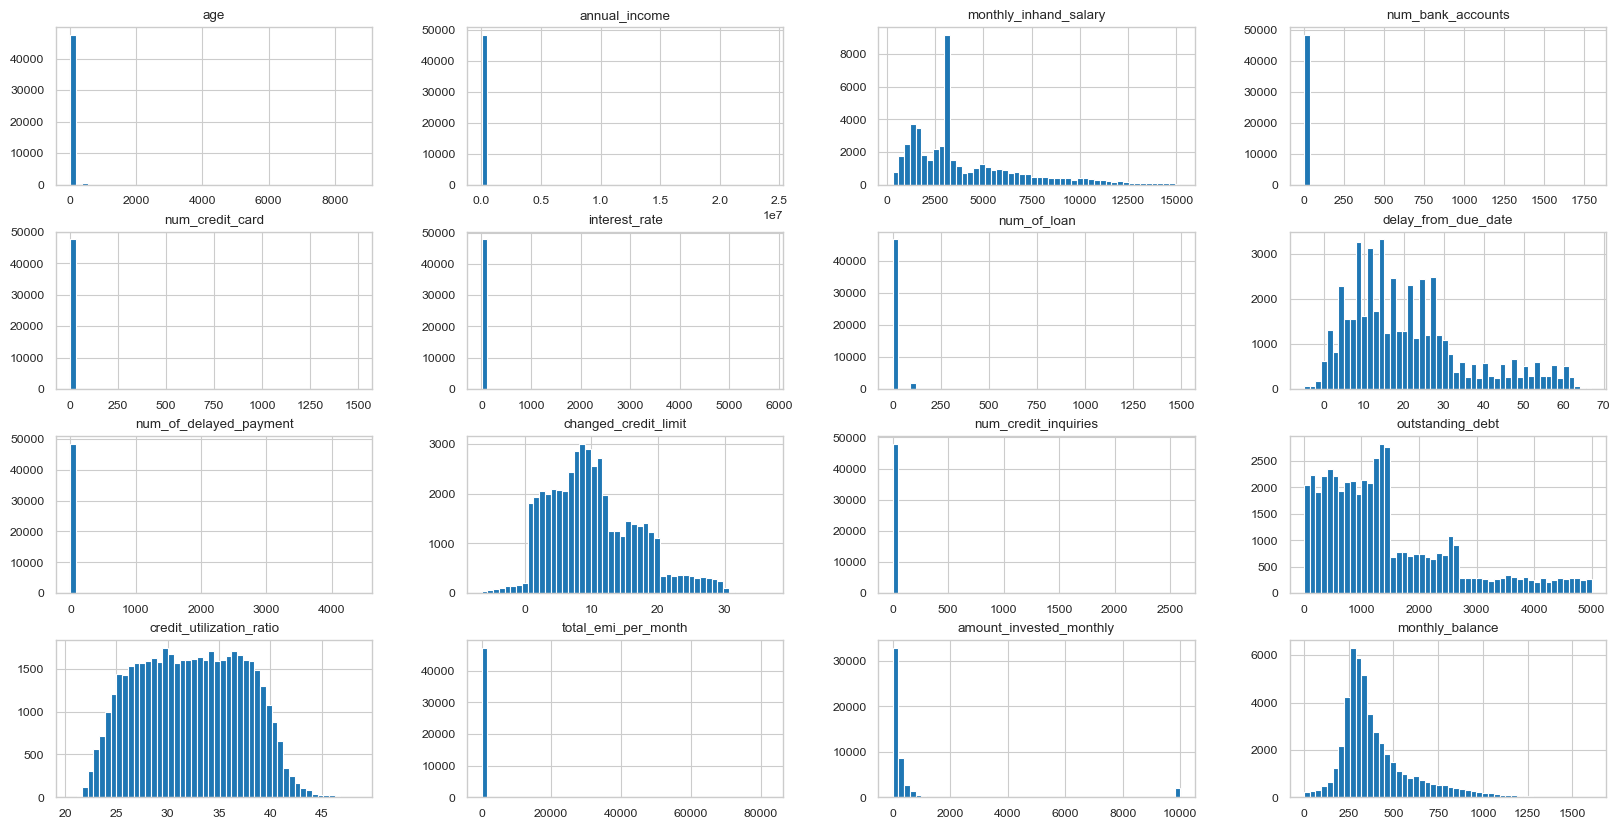

In [322]:
df_num.hist(bins=50, figsize=[20,10])

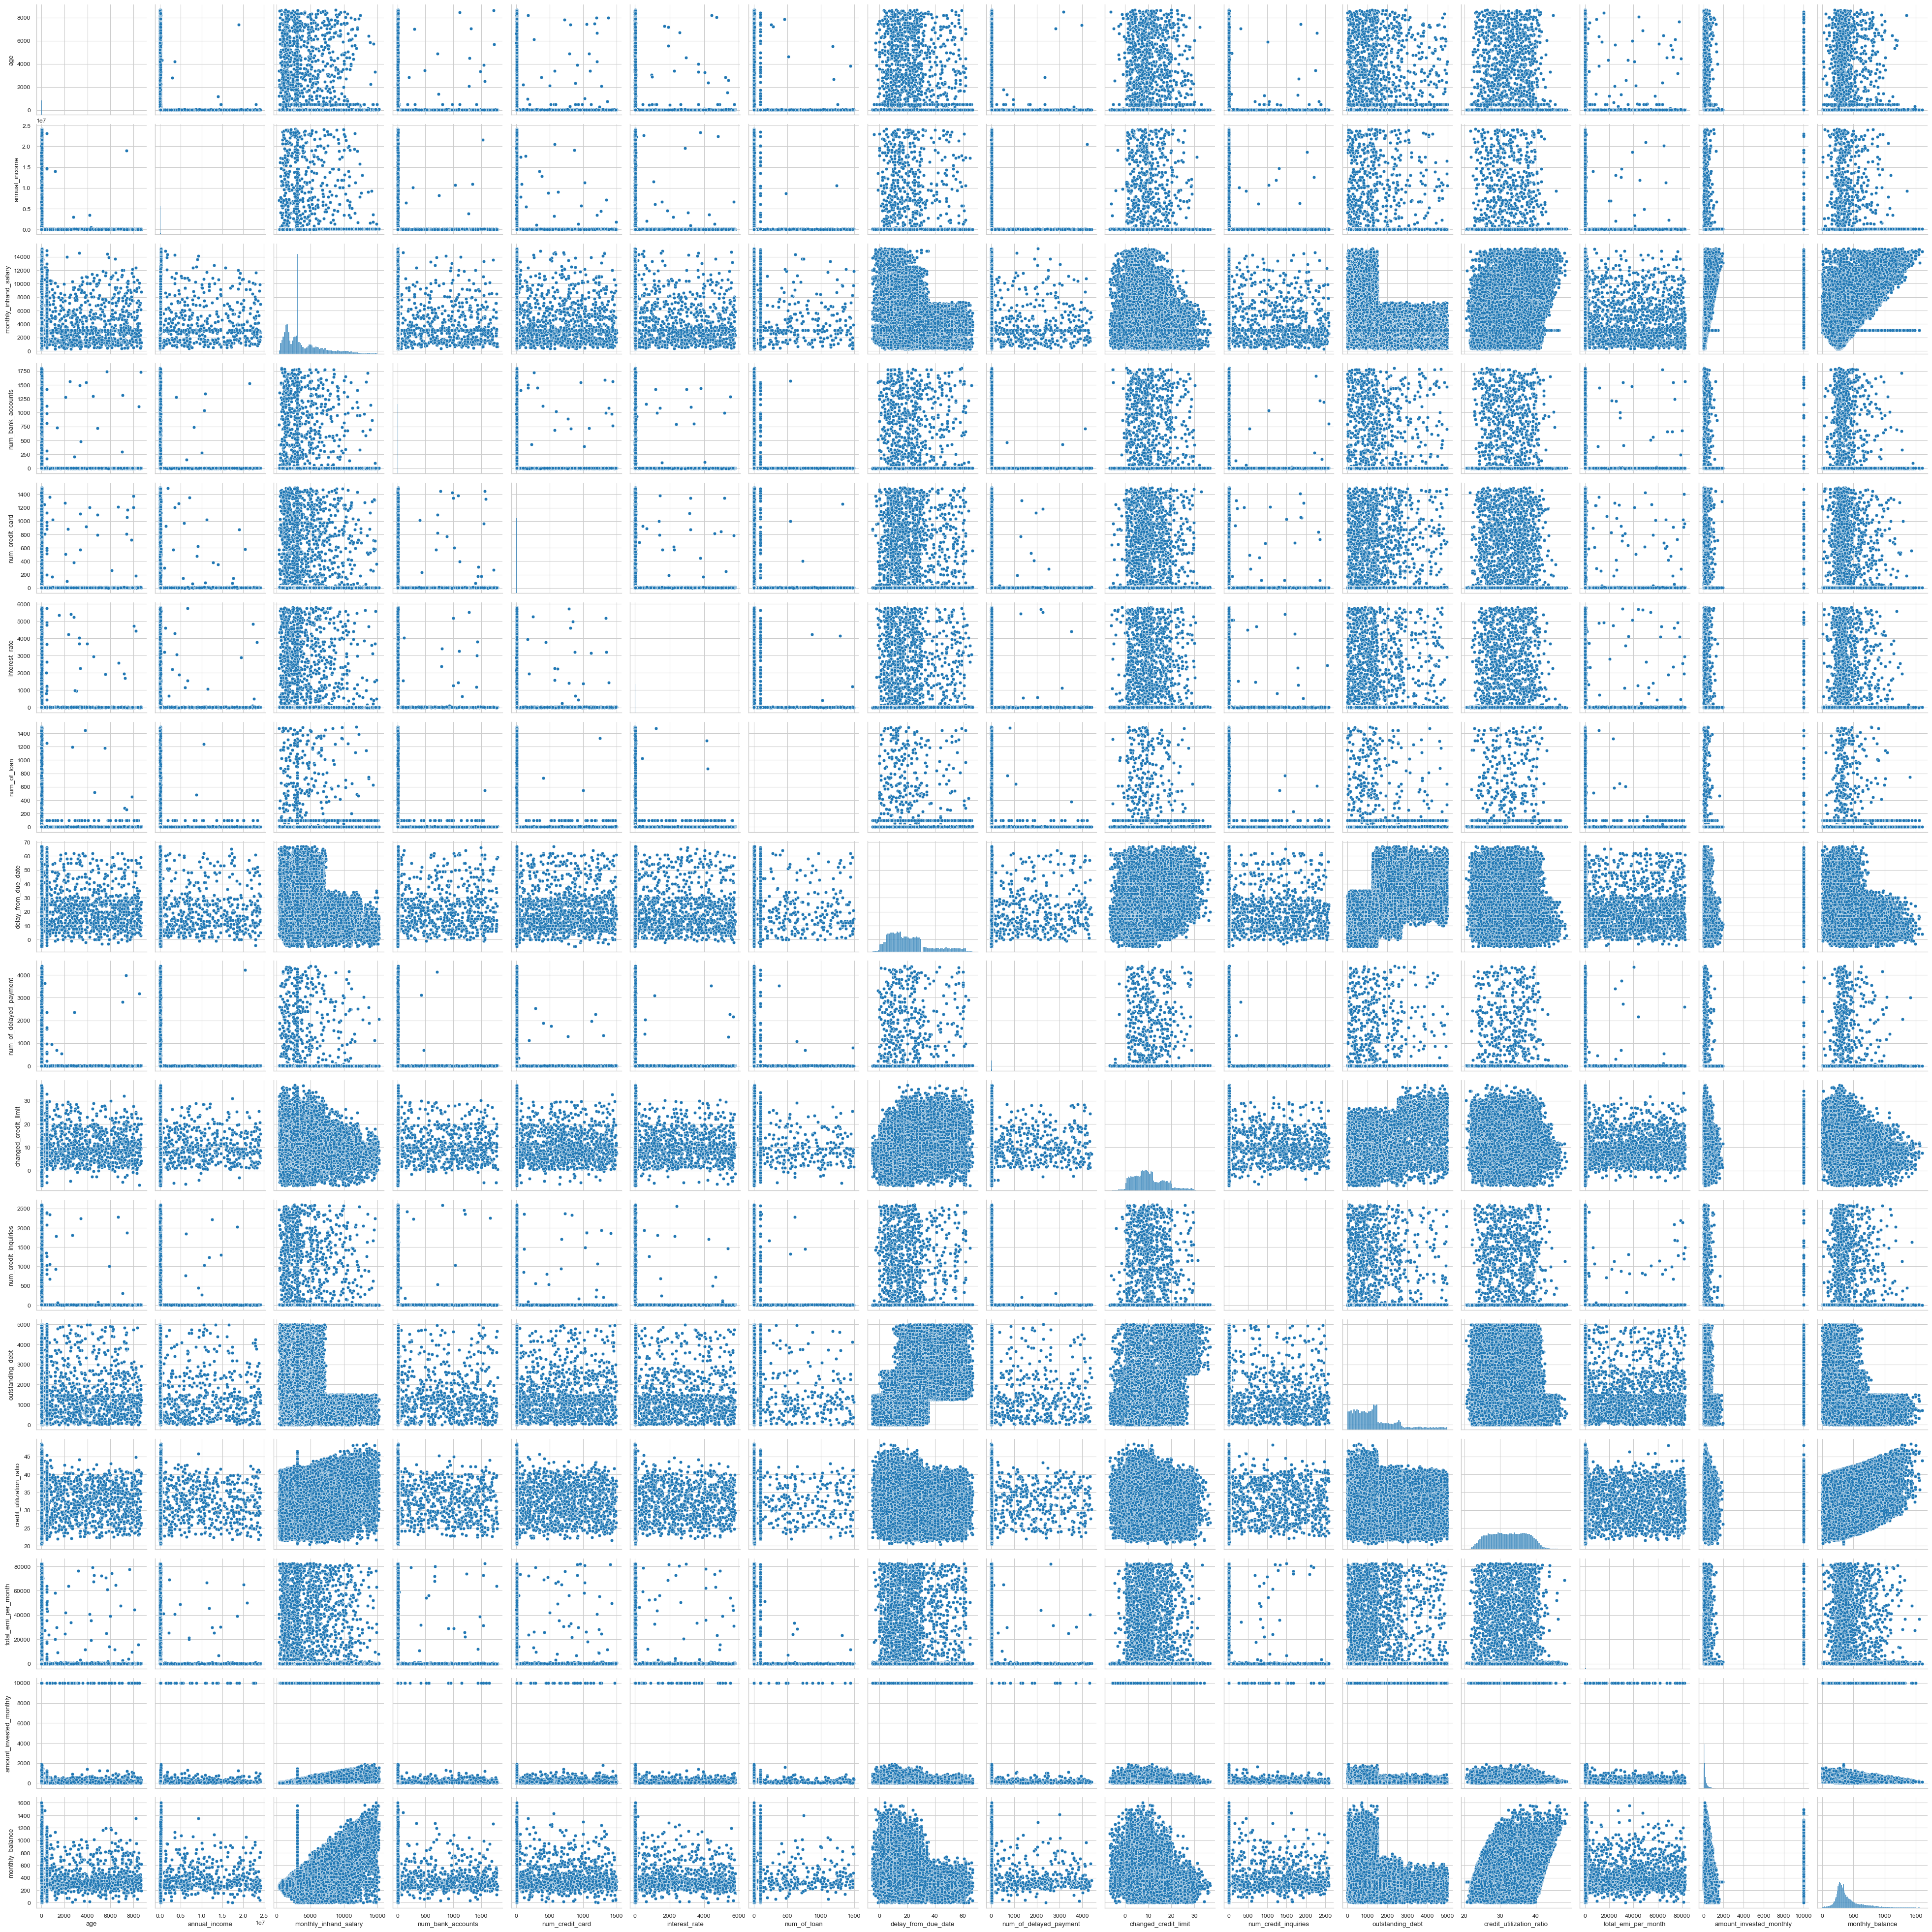

In [323]:
sns.pairplot(df_num)

In [324]:
corrmat = df_num.corr()
corrmat

age  annual_income  monthly_inhand_salary   
age                       1.00          -0.01                   0.00  \
annual_income            -0.01           1.00                   0.03   
monthly_inhand_salary     0.00           0.03                   1.00   
num_bank_accounts         0.01           0.00                  -0.01   
num_credit_card           0.00          -0.00                  -0.00   
interest_rate             0.00           0.00                  -0.01   
num_of_loan               0.00          -0.00                  -0.00   
delay_from_due_date       0.00          -0.01                  -0.23   
num_of_delayed_payment    0.00          -0.00                  -0.01   
changed_credit_limit      0.00          -0.01                  -0.16   
num_credit_inquiries     -0.00           0.00                  -0.01   
outstanding_debt         -0.00          -0.01                  -0.25   
credit_utilization_ratio  0.00          -0.00                   0.15   
total_emi_per_month       0.00          -0.00                   0.02   
amount_invested_monthly   0.00           0.01                   0.05   
monthly_balance          -0.00           0.02                   0.64   

                          num_bank_accounts  num_credit_card  interest_rate   
age                                    0.01             0.00           0.00  \
annual_income                          0.00            -0.00           0.00   
monthly_inhand_salary                 -0.01            -0.00          -0.01   
num_bank_accounts                      1.00             0.01           0.00   
num_credit_card                        0.01             1.00          -0.00   
interest_rate                          0.00            -0.00           1.00   
num_of_loan                           -0.00            -0.00           0.00   
delay_from_due_date                    0.02             0.01           0.01   
num_of_delayed_payment                -0.00            -0.00           0.00   
changed_credit_limit                   0.01             0.01           0.01   
num_credit_inquiries                   0.00             0.00          -0.00   
outstanding_debt                       0.01             0.01           0.01   
credit_utilization_ratio              -0.00             0.00          -0.00   
total_emi_per_month                    0.00             0.00           0.01   
amount_invested_monthly               -0.01            -0.01          -0.00   
monthly_balance                       -0.01            -0.01          -0.01   

                          num_of_loan  delay_from_due_date   
age                              0.00                 0.00  \
annual_income                   -0.00                -0.01   
monthly_inhand_salary           -0.00                -0.23   
num_bank_accounts               -0.00                 0.02   
num_credit_card                 -0.00                 0.01   
interest_rate                    0.00                 0.01   
num_of_loan                      1.00                 0.02   
delay_from_due_date              0.02                 1.00   
num_of_delayed_payment           0.00                 0.02   
changed_credit_limit             0.01                 0.29   
num_credit_inquiries            -0.00                 0.00   
outstanding_debt                 0.02                 0.57   
credit_utilization_ratio        -0.00                -0.07   
total_emi_per_month             -0.01                 0.00   
amount_invested_monthly          0.01                -0.01   
monthly_balance                 -0.01                -0.29   

                          num_of_delayed_payment  changed_credit_limit   
age                                         0.00                  0.00  \
annual_income                              -0.00                 -0.01   
monthly_inhand_salary                      -0.01                 -0.16   
num_bank_accounts                          -0.00                  0.01   
num_credit_card                  

<Axes: >

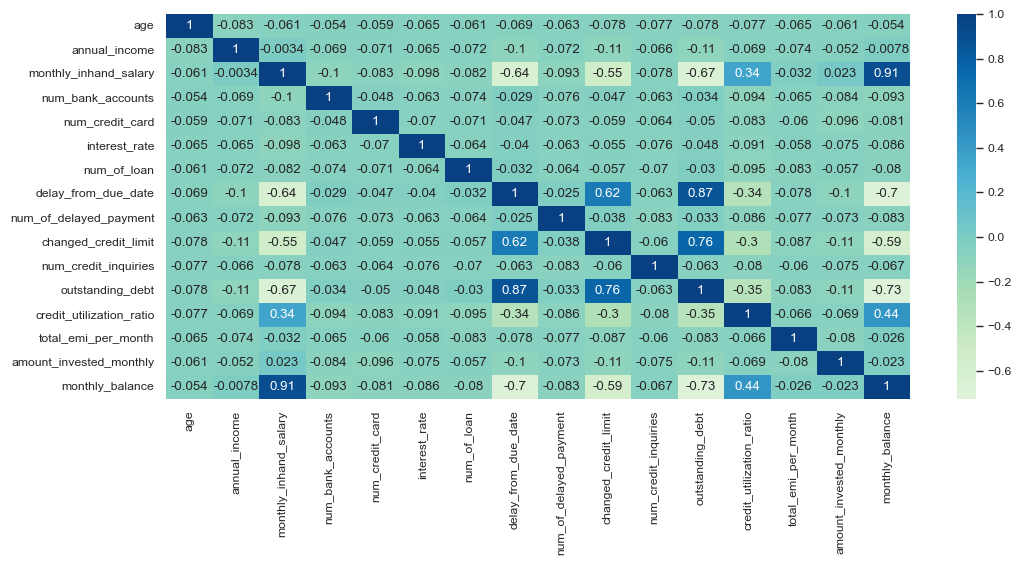

In [325]:
plt.figure(figsize=(12,5))
sns.heatmap(corrmat.corr(), cmap="GnBu", center=0, annot=True)


In [326]:
numeric_cols = df.select_dtypes(exclude="object").columns
cat_col = df.select_dtypes(include="object").columns
numeric_cols

Index(['age', 'annual_income', 'monthly_inhand_salary', 'num_bank_accounts',
       'num_credit_card', 'interest_rate', 'num_of_loan',
       'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit',
       'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio',
       'total_emi_per_month', 'amount_invested_monthly', 'monthly_balance'],
      dtype='object')

In [327]:
cat_col

Index(['occupation', 'credit_mix', 'payment_of_min_amount',
       'payment_behaviour', 'changed_credit_Limit'],
      dtype='object')

In [328]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_df = df[numeric_cols]

vif_data = pd.DataFrame()
vif_data['feature'] = vif_df.columns
vif_data['VIF'] = [variance_inflation_factor(vif_df.values, i) for i in range(len(vif_df.columns))]
vif_data.head(17)

feature   VIF
0                        age  1.03
1              annual_income  1.02
2      monthly_inhand_salary  4.82
3          num_bank_accounts  1.02
4            num_credit_card  1.03
5              interest_rate  1.02
6                num_of_loan  1.03
7        delay_from_due_date  4.43
8     num_of_delayed_payment  1.02
9       changed_credit_limit  4.12
10      num_credit_inquiries  1.02
11          outstanding_debt  4.43
12  credit_utilization_ratio 10.58
13       total_emi_per_month  1.03
14   amount_invested_monthly  1.10
15           monthly_balance  8.39

In [329]:
df = df.drop(['monthly_inhand_salary', 'changed_credit_limit', 'outstanding_debt', 'credit_utilization_ratio', 'monthly_balance'],axis=1)